- references
    - https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models

forward noising process (forward sde, from data to noise)

$$
q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb 1)
$$

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 对比 VAE

> 为什么叫 diffusion 而不是一种 VAE

- Encoder: $q(z|x)$, $x_0\rightarrow z_T$
- Decoder: $p(x|z)$, $z_T\rightarrow x_0$

- a diffusion process is a **stochastic** **Markov** process
    - with no jumps

$$
P(X_t|X_{t-1},X_{t-2} \cdots, X_1, X_0)=P(X_t|X_{t-1})
$$

## SDE

$$
\begin{split}
&dx=f(x,t)dt+g(t)dw\\
\end{split}
$$

$$
\begin{split}
q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb I)&=\sqrt{1-\beta}x_{t-1}+\sqrt\beta \mathcal N(0, \mathbb 1)\\
&=x_{t-1}-\underbrace{(1-\sqrt{1-\beta})x_{t-1}}_{deterministic} + \underbrace{\sqrt\beta \mathcal N(0, \mathbb I)}_{stochastic}
\end{split}
$$


$$
\begin{split}
&x_t=\sqrt{1-\beta}x_{t-1}+\sqrt \beta\mathcal N(0, \mathbb 1)\\
&x_t=\alpha x_{t-1} + \beta \mathcal N(0, \mathbb 1)\\
&x_t=\sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\mathcal N(0, \mathbb 1)\\
\end{split}
$$

$$
x_T=\sqrt{1-\beta}^Tx_0+\cdots+\sqrt{1-\beta}^2\sqrt\beta\mathcal N(0,\mathbb 1)+\sqrt{1-\beta}\sqrt\beta\mathcal N(0,\mathbb 1)+\sqrt\beta\mathcal N(0,\mathbb1)
$$

Text(0.5, 1.0, 'Diffusion Process Example: Random Walk')

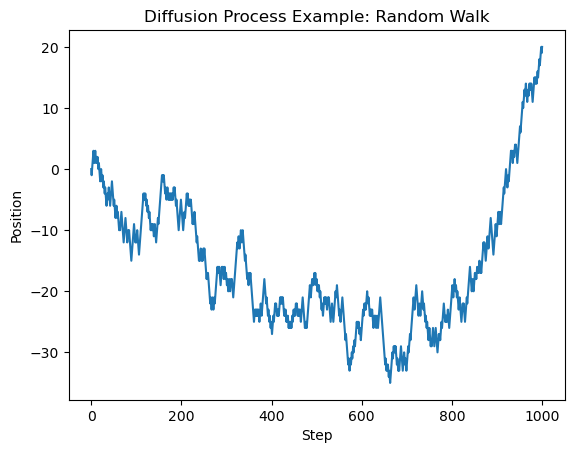

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化参数
initial_position = 0  # 初始位置
steps = 1000  # 总步数
step_size = 1  # 每步移动的距离

# 初始化位置数组
positions = np.zeros(steps+1)
positions[0] = initial_position

# 执行向前扩散过程
for i in range(1, steps+1):
    # 随机选择方向并移动
    step_direction = np.random.choice([-1, 1])  # 随机选择前进或后退
    positions[i] = positions[i-1] + step_direction * step_size

# 绘制路径图
plt.plot(positions)
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('Diffusion Process Example: Random Walk')

### $\beta_t$ scheduler

$\beta_t$ refers to something called schedule and values can range from 0 to 1.

- $\beta_1=0.0001$, $\beta_T=0.02$